## 이상치
- 결측치, 범위에서 벗어난 데이터, 값이 크게 벗어나는 데이터
- 분석 모델 성능을 떨어뜨리거나 결과에 악영향을 미치는 경우가 발생
- 이상치를 발견하면 확인 후 특정한 값을 대치하거나 삭제
- IQR 방식
    - matplotlib 에서 boxplot의 이상치 결정 방법
    - n = 1.5
    - 순서
        - Q3(3사분위수)와 Q1(1사분위수)로 범위를 지정
        - 이상치의 경계 (Q3 + 1.5IQR) ~ (Q1 - 1.5IQR)
        - 많은 데이터를 이상치 판달할 수 있다
        - 1.5 값을 조정해서 이상치의 범위를 변경

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

### sklearn 데이터 가져오기

In [3]:
load_wine().keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [4]:
wine_load = pd.DataFrame(load_wine().data, columns = load_wine().feature_names)

In [5]:
wine_load

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [6]:
wine_load['class'] = load_wine().target

In [7]:
wine_load.head(1)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0


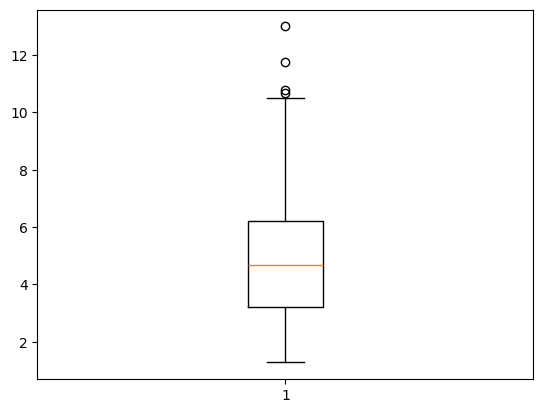

In [8]:
plt.boxplot(wine_load['color_intensity'])
plt.show()


### 이상치의 경계

In [9]:
wine_load['color_intensity'].describe().loc[['25%', '75%']]

25%    3.22
75%    6.20
Name: color_intensity, dtype: float64

In [12]:
np.percentile(wine_load['color_intensity'], [25, 75])

array([3.22, 6.2 ])

In [ ]:
q_1, q_3 = np.percentile(wine_load['color_intensity'], [25, 75])

In [14]:
iqr = q_3 - q_1

upper_whis = q_3 + 1.5*iqr
down_whis = q_1 - 1.5*iqr

print(upper_whis, down_whis)

10.670000000000002 -1.2500000000000009


In [16]:
# min이 1.28 down_whis가 -1.25니까 아래에 이상치가 없다
wine_load['color_intensity'].describe()

count    178.000000
mean       5.058090
std        2.318286
min        1.280000
25%        3.220000
50%        4.690000
75%        6.200000
max       13.000000
Name: color_intensity, dtype: float64

### [함수생성] iqr을 이용한 이상치 판단 함수 생성
- 매개변수
    - df
    - 기준이되는 컬럼(가변)
    - cnt = 1.5
- 기준이 되는 컬럼의 개수만큼 반복 실행
    - 컬럼의 데이터를 기준으로 Q1, Q3를 생성 
    - IQR 변수를 생성
    - 상단의 경계와 하단의 경계를 생성
    - 경계를 활용하여 데이터프레임에서 이상치를 출력
    - 딕셔너리(컬럼의이름 : 데이터프레임)
- 딕셔너리 반환

In [29]:
def outlier_iqr(
    _df,
    *_cols,
    cnt = 1.5
):
    result = dict()
    
    for col in _cols:
        q_1, q_3 = np.percentile(_df[col], [25, 75])
        iqr = q_3 - q_1
        up_whis = q_3 + cnt * iqr
        down_whis = q_1 - cnt * iqr
        print(f"{col} 컬럼 데이터의 상단경계는 {up_whis}, 하단경계는 {down_whis}")
        flag = (_df[col] < down_whis) | (_df[col] > up_whis)
        # print(_df.loc[flag])
        result[col] = _df.loc[flag]
        
    return result
    

In [33]:
outlier = outlier_iqr(wine_load,'color_intensity', 'alcalinity_of_ash')

color_intensity 컬럼 데이터의 상단경계는 10.670000000000002, 하단경계는 -1.2500000000000009
alcalinity_of_ash 컬럼 데이터의 상단경계는 27.950000000000003, 하단경계는 10.749999999999998


## 이상치 정제
1. 이상치 제거
    - 데이터의 개수가 매우 많고, 이상치가 존재하는 데이터의 개수가 전체 데이터에 비해 많지 않은 경우에는 제거
    - 이상치를 제거 -> 데이터의 개수가 줄어든다 
2. 이상치 대체
    - 이상치의 값을 다른 값으로 대체한다. 
    - 데이터분석가에 따라 (다른 값)이 달라진다

### 이상치 제거

In [35]:
outlier['color_intensity'].index

Index([151, 158, 159, 166], dtype='int64')

In [ ]:
wine_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  class

In [39]:
# 이상치가 제거된 데이터의 길이 178 -> 174
wine_load.drop(outlier['color_intensity'].index, axis=0, inplace=True)

In [40]:
wine_load

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


### 이상치 대체

In [57]:
df2 = wine_load.copy()
print(df2['alcalinity_of_ash'].mean())
df2.loc[outlier['alcalinity_of_ash'].index, 'alcalinity_of_ash'] = df2['alcalinity_of_ash'].mean()

19.411494252873567


In [59]:
df2.loc[outlier['alcalinity_of_ash'].index, 'alcalinity_of_ash']

59     19.411494
73     19.411494
121    19.411494
127    19.411494
Name: alcalinity_of_ash, dtype: float64

In [66]:
df3 = wine_load.copy()
up_whis = 27.950000000000003
down_whis = 10.749999999999998

df3.loc[df3['alcalinity_of_ash'] > up_whis, 'alcalinity_of_ash'] = up_whis
df3.loc[df3['alcalinity_of_ash'] < down_whis, 'alcalinity_of_ash'] = down_whis
df3.loc[outlier['alcalinity_of_ash'].index]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
59,12.37,0.94,1.36,10.75,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0,1
73,12.99,1.67,2.60,27.95,139.0,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985.0,1
121,11.56,2.05,3.23,27.95,119.0,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465.0,1
127,11.79,2.13,2.78,27.95,92.0,2.13,2.24,0.58,1.76,3.00,0.97,2.44,466.0,1


## 범주형 변수 이상치
- 범주형 변수는 같이 수학작 연산으로 모델을 생성하는 대부분 분석 도구에서 직접적으로 사용하기 어렵기 때문에 특별 가공 처리
- 더미변수 사용
- 더미변수는 범주형 변수에 있는 범주들을 각각 컬럼으로 변경 -> 0과 1로 데이터를 대입하여 포함 여부를 보여주는 변수

### 더미변수 생성

In [68]:
wine_load['class'].map(
    {
        0:'Class_0',
        1:'Class_1',
        2:'Class_2'
    }
).value_counts()

class
Class_1    71
Class_0    59
Class_2    44
Name: count, dtype: int64

In [69]:
wine_load['class'] = wine_load['class'].map(
    {
        0:'Class_0',
        1:'Class_1',
        2:'Class_2'
    }
)

In [71]:
wine_dummy = pd.get_dummies(wine_load, columns=['class'])

In [73]:
wine_dummy['class_Class_1'].value_counts()

class_Class_1
False    103
True      71
Name: count, dtype: int64

## 데이터 분할
- 분석 모델을 학습하고 결과를 확인하기 위하여 데이터를 train과 test 세트로 나누고 독립변수와 종속변수를 분리하는 작업
1. train : test = 7 : 3
2. train : validation : test = 6 : 2 : 2
- sklearn의 train_test_split()
    - train_test_split(X, Y, test_size = None, random_state = None, shuffle = True, stratify = None)
        - X : 독립 변수
        - Y : 종속 변수
        - test_size : test 데이터 비율
        - random_state :  임의의 번호를 지정, 같은 숫자를 사용하면 같은 출력 생성됨
        - shuffle : True 라면 데이터를 추출하기 전에 순서를 섞는다 
        - stratify : None이 아니라면 데이터는 지정한 변수를 기준으로 계층화되어 해당 변수의 비율을 유지하도록 추출

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

iris_load = load_iris()

iris_load.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [83]:
iris = pd.DataFrame(iris_load.data, columns=iris_load.feature_names)

iris.head(1)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2


In [87]:
iris_load.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [92]:
iris['class'] = iris_load.target

iris['class'] = iris['class'].map(
    {
        0:'setosa',
        1:'versicolor',
        2:'virginica'
    }
)

In [93]:
iris.head(20)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


In [94]:
iris['class'].value_counts()

class
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [109]:
x_train, x_test, y_train, y_test = train_test_split(
                                    iris.drop('class', axis=1),
                                    iris['class'],
                                    test_size=0.3,
                                    random_state=1000)

print(len(x_train), len(x_test), len(y_train), len(y_test))

105 45 105 45


In [110]:
y_train.value_counts()

class
setosa        39
versicolor    34
virginica     32
Name: count, dtype: int64

In [129]:
y_test

95     versicolor
34         setosa
127     virginica
120     virginica
24         setosa
28         setosa
84     versicolor
68     versicolor
38         setosa
123     virginica
132     virginica
74     versicolor
44         setosa
4          setosa
144     virginica
67     versicolor
119     virginica
82     versicolor
37         setosa
49         setosa
81     versicolor
70     versicolor
125     virginica
141     virginica
57     versicolor
15         setosa
85     versicolor
97     versicolor
60     versicolor
137     virginica
23         setosa
62     versicolor
143     virginica
64     versicolor
39         setosa
108     virginica
111     virginica
66     versicolor
101     virginica
102     virginica
126     virginica
148     virginica
115     virginica
91     versicolor
121     virginica
Name: class, dtype: object

In [119]:
# stratify = iris['class'](Y_train)
X_train, X_test, Y_train, Y_test = train_test_split(
                                    iris.drop('class', axis=1),
                                    iris['class'],
                                    test_size=0.3,
                                    stratify=iris['class'],
                                    random_state=10)

print(len(x_train), len(x_test), len(y_train), len(y_test))

105 45 105 45


In [128]:
Y_test

9          setosa
125     virginica
15         setosa
117     virginica
55     versicolor
38         setosa
98     versicolor
90     versicolor
16         setosa
57     versicolor
112     virginica
141     virginica
137     virginica
43         setosa
143     virginica
56     versicolor
49         setosa
8          setosa
130     virginica
54     versicolor
48         setosa
36         setosa
144     virginica
29         setosa
147     virginica
74     versicolor
148     virginica
94     versicolor
11         setosa
142     virginica
146     virginica
82     versicolor
92     versicolor
132     virginica
63     versicolor
0          setosa
116     virginica
126     virginica
25         setosa
84     versicolor
65     versicolor
93     versicolor
46         setosa
28         setosa
89     versicolor
Name: class, dtype: object

In [121]:
Y_train.value_counts()

class
setosa        35
versicolor    35
virginica     35
Name: count, dtype: int64